In [16]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats

# CMA aging Atlas: Heart
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Heart data, Smart-seq2 assay in .h5ad format was used for further analysis.

## Importing and preprocessing data

In [4]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + 'TM_heart.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [5]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx)

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 16/16 [00:00<00:00, 11407.25it/s]
9669it [00:10, 924.78it/s]


In [6]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,fibroblast of cardiac tissue,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457


## CMA net score/cell type (fold over whole tissue)

In [6]:
# Checking n of mice 
print(list(barcode['mouse.id'].unique()))

['18_46_F', '18_53_M', '18_47_F', '24_60_M', '24_61_M', '24_59_M', '24_58_M', '3_56_F', '3_39_F', '3_38_F', '3_9_M', '3_8_M', '3_11_M', '3_10_M', '3_10_M/3_11_M', '3_38_F/3_39_F']


**Mice n for Liver**
    - Young females: 4
    - Young males: 4
    - Old females: 2
    - Old males: 5

In [7]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m


In [8]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m,-0.001115
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m,0.164504
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m,0.067043
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,normal,Mus musculus,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m,-0.134883
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m,-0.042355


In [9]:
print(list(barcode.cell_type.unique()))

['B cell', 'fibroblast of cardiac tissue', 'endothelial cell of coronary artery', 'monocyte', 'macrophage', 'endocardial cell', 'cardiac valve cell', 'regular atrial cardiac myocyte', 'T cell', 'smooth muscle cell', 'regular ventricular cardiac myocyte']


In [10]:
# Generating new cell types combining some of them
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'cell_type'] == 'fibroblast of cardiac tissue':        
        barcode.loc[j, 'new_cell'] = 'fibroblast'

    elif barcode.loc[j, 'cell_type'] == 'endothelial cell of coronary artery':                
        barcode.loc[j, 'new_cell'] = 'endothelial cell'
    
    elif barcode.loc[j, 'cell_type'] == 'regular atrial cardiac myocyte':                
        barcode.loc[j, 'new_cell'] = 'myocyte'
    
    elif barcode.loc[j, 'cell_type'] == 'regular ventricular cardiac myocyte':                
        barcode.loc[j, 'new_cell'] = 'myocyte'
        
    else:
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']
        
barcode.head()

100%|██████████| 9669/9669 [00:00<00:00, 17851.07it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,new_cell
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,Mus musculus,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m,-0.001115,B cell
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,Mus musculus,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m,0.164504,B cell
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,Mus musculus,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m,0.067043,B cell
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,Mus musculus,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m,-0.134883,fibroblast
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,Mus musculus,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m,-0.042355,B cell


In [11]:
cells = ['myocyte']

## CMA net score/cell type & sex (fold over each cell type young)

In [12]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

100%|██████████| 10/10 [00:00<00:00, 18.69it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,new_cell,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m,-0.001115,B cell,0.133102
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m,0.164504,B cell,0.298720
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m,0.067043,B cell,0.201260
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m,-0.134883,fibroblast,-0.148490
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m,-0.042355,B cell,0.091862


### Graphs

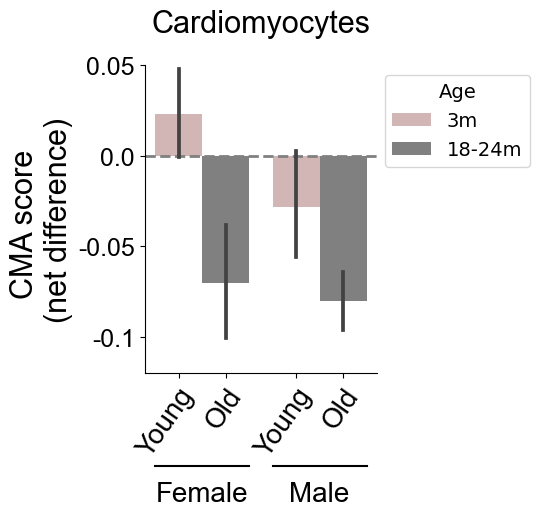

In [13]:
# Figure Cardiomyocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='myocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.12, 0.05)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Cardiomyocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)


plt.savefig(output_dir + '/Heart/Myo_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [17]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Heart/Raw_data.xlsx", sheet_name="CellNsbysex", index=False)
        
    return(df_raw)

In [18]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

,Cell_type,Age,Sex,n,Mean,SEM
0,myocyte,3m,female,113,0.023128,0.024567
1,myocyte,3m,male,92,-0.028407,0.030156
2,myocyte,18-24m,female,65,-0.070391,0.032801
3,myocyte,18-24m,male,280,-0.080280,0.016114


## CMA network heatmaps by cell type & sex

In [19]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [20]:
# Function for heatmap
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    # Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    # Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    # Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Heart/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop+'_heat', index=True)
        
    # Plot heatmap        
    
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    
    plt.savefig(output_dir + '/Heart/{}_heat.png'.format(cellpop),bbox_inches='tight', dpi=300)
    
    plt.show()

100%|██████████| 16/16 [00:00<00:00, 41.82it/s]


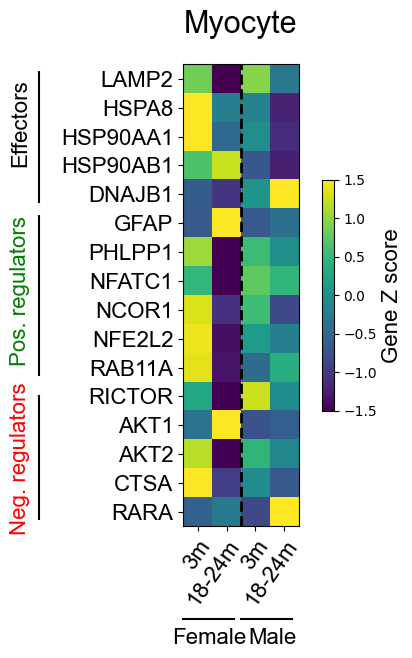

In [21]:
sex_heatmaps(cellpop='myocyte')